In [1]:
# Togo EDA Notebook
# Objective: Profile, clean, and explore Togo's solar dataset end-to-end.

import os
import warnings
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_context("talk")

COUNTRY = "togo"
RAW_DATA_PATH = os.path.join("..", "data", f"{COUNTRY}-dapaong_qc.csv")
CLEAN_DATA_PATH = os.path.join("..", "data", f"{COUNTRY}_clean.csv")

# Known columns (seen in the dataset header)
NUMERIC_CANDIDATES: List[str] = [
    "GHI", "DNI", "DHI", "Tamb", "TModA", "TModB",
    "ModA", "ModB", "WS", "WSgust", "WSstdev", "WD", "WDstdev", "RH", "BP"
]
TIME_COLUMN_CANDIDATES: List[str] = ["Timestamp", "timestamp", "time", "Date", "Datetime"]
CLEANING_FLAG_CANDIDATES: List[str] = ["Cleaning", "cleaned", "is_cleaned"]


def find_first_column(df: pd.DataFrame, candidates: List[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None


def existing_columns(df: pd.DataFrame, cols: List[str]) -> List[str]:
    return [c for c in cols if c in df.columns]

print(f"Expecting raw CSV at: {RAW_DATA_PATH}")
if not os.path.exists(RAW_DATA_PATH):
    print("WARNING: Raw data file not found. Place the CSV at:", RAW_DATA_PATH)



Expecting raw CSV at: ..\data\togo-dapaong_qc.csv


In [2]:
# Load data
try:
    df = pd.read_csv(RAW_DATA_PATH, low_memory=False)
    print("Loaded:", df.shape)
    time_col = find_first_column(df, TIME_COLUMN_CANDIDATES)
    if time_col is not None:
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        df = df.sort_values(by=time_col)
    else:
        print("No time-like column found in:", TIME_COLUMN_CANDIDATES)
except FileNotFoundError:
    df = pd.DataFrame()
    print("Data not found. Place the CSV and re-run this cell.")


Loaded: (525600, 19)


In [3]:
# Summary statistics & missing values
if not df.empty:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    display(df[num_cols].describe().T)

    na_series = df.isna().sum().sort_values(ascending=False)
    na_pct = (na_series / len(df) * 100).round(2)
    missing_report = pd.DataFrame({"missing": na_series, "%": na_pct})
    display(missing_report[missing_report["%"] > 0])

    gt5 = missing_report[missing_report["%"] > 5]
    if not gt5.empty:
        print("Columns with >5% nulls:")
        display(gt5)
else:
    print("DataFrame is empty.")


,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,230.555040,322.532347,-12.7,-2.2,2.1,442.400,1424.0
DNI,525600.0,151.258469,250.956962,0.0,0.0,0.0,246.400,1004.5
DHI,525600.0,116.444352,156.520714,0.0,0.0,2.5,215.700,805.7
ModA,525600.0,226.144375,317.346938,0.0,0.0,4.4,422.525,1380.0
ModB,525600.0,219.568588,307.932510,0.0,0.0,4.3,411.000,1367.0
Tamb,525600.0,27.751788,4.758023,14.9,24.2,27.2,31.100,41.4
RH,525600.0,55.013160,28.778732,3.3,26.5,59.3,80.800,99.8
WS,525600.0,2.368093,1.462668,0.0,1.4,2.2,3.200,16.1
WSgust,525600.0,3.229490,1.882565,0.0,1.9,2.9,4.400,23.1
WSstdev,525600.0,0.557740,0.268923,0.0,0.4,0.5,0.700,4.7


,missing,%
Comments,525600,100.0


Columns with >5% nulls:


,missing,%
Comments,525600,100.0


In [4]:
# Outlier detection (Z-scores) and basic cleaning
if not df.empty:
    cols_to_check = [c for c in ["GHI","DNI","DHI","ModA","ModB","WS","WSgust"] if c in df]
    print("Z-score columns:", cols_to_check)

    z_df = pd.DataFrame(index=df.index)
    for c in cols_to_check:
        series = pd.to_numeric(df[c], errors='coerce')
        z = stats.zscore(series, nan_policy='omit')
        z_df[c] = z

    z_flag = (z_df.abs() > 3).any(axis=1)
    print("Rows with any |Z|>3:", int(z_flag.sum()))

    cleaned = df.copy()
    for c in cols_to_check:
        cleaned[c] = pd.to_numeric(cleaned[c], errors='coerce')
        if cleaned[c].isna().any():
            cleaned[c] = cleaned[c].fillna(cleaned[c].median())

    # Keep a reference for later plots/exports
    cleaned_df = cleaned
    display(cleaned_df[cols_to_check].describe().T)
else:
    print("DataFrame is empty.")


Z-score columns: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
Rows with any |Z|>3: 9251


,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,230.555040,322.532347,-12.7,-2.2,2.1,442.400,1424.0
DNI,525600.0,151.258469,250.956962,0.0,0.0,0.0,246.400,1004.5
DHI,525600.0,116.444352,156.520714,0.0,0.0,2.5,215.700,805.7
ModA,525600.0,226.144375,317.346938,0.0,0.0,4.4,422.525,1380.0
ModB,525600.0,219.568588,307.932510,0.0,0.0,4.3,411.000,1367.0
WS,525600.0,2.368093,1.462668,0.0,1.4,2.2,3.200,16.1
WSgust,525600.0,3.229490,1.882565,0.0,1.9,2.9,4.400,23.1


In [5]:
# Export cleaned dataset
if 'cleaned_df' in globals() and not cleaned_df.empty:
    os.makedirs(os.path.dirname(CLEAN_DATA_PATH), exist_ok=True)
    cleaned_df.to_csv(CLEAN_DATA_PATH, index=False)
    print("Exported:", CLEAN_DATA_PATH)
else:
    print("No cleaned data to export.")


Exported: ..\data\togo_clean.csv


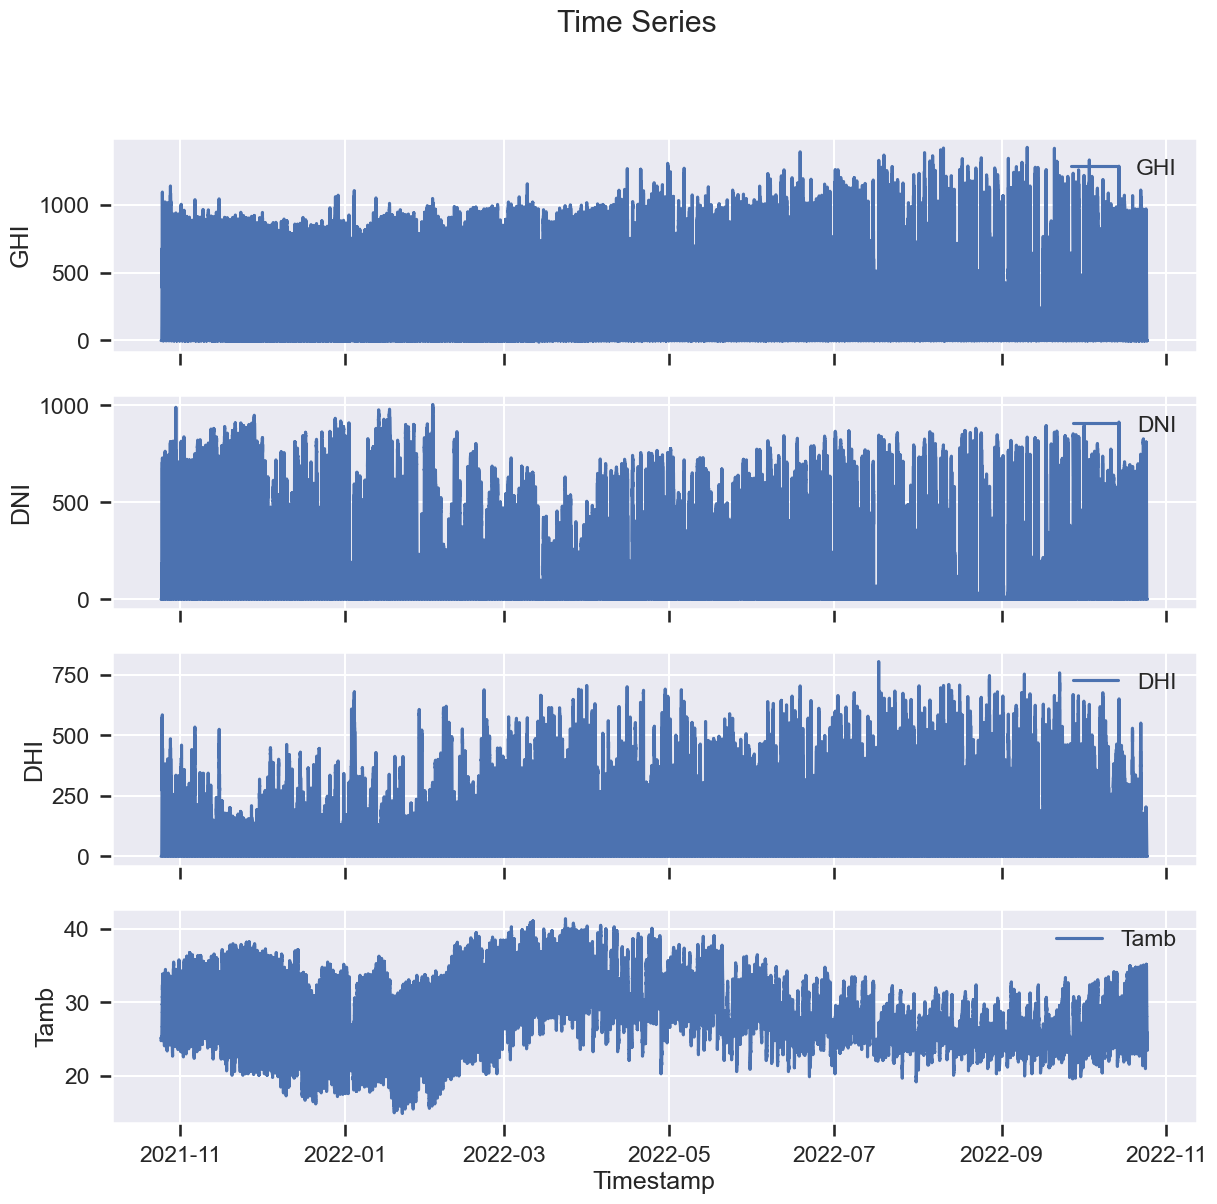

In [6]:
# Time series: GHI, DNI, DHI, Tamb vs time
if not df.empty:
    tcol = find_first_column(df, TIME_COLUMN_CANDIDATES)
    if tcol and pd.api.types.is_datetime64_any_dtype(df[tcol]):
        ts_cols = [c for c in ["GHI","DNI","DHI","Tamb"] if c in df]
        if ts_cols:
            fig, axes = plt.subplots(len(ts_cols), 1, figsize=(14, 3.2*len(ts_cols)), sharex=True)
            if len(ts_cols) == 1: axes = [axes]
            for ax, c in zip(axes, ts_cols):
                ax.plot(df[tcol], df[c], label=c)
                ax.set_ylabel(c); ax.legend(loc="upper right")
            axes[-1].set_xlabel(tcol)
            plt.suptitle("Time Series")
            plt.show()
        else:
            print("No TS columns present.")
    else:
        print("Timestamp column missing or not datetime.")
else:
    print("DataFrame is empty.")


,ModA,ModB
Cleaning,,
0,225.979064,219.401351
1,535.186477,532.211744


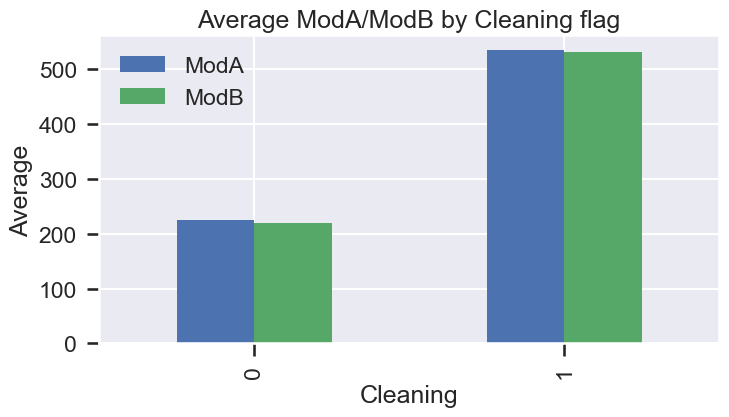

In [7]:
# Cleaning impact: average ModA & ModB by Cleaning flag
if not df.empty:
    flag_col = find_first_column(df, CLEANING_FLAG_CANDIDATES)
    target_cols = [c for c in ["ModA","ModB"] if c in df]
    if flag_col and target_cols:
        grp = df.groupby(flag_col)[target_cols].mean().rename_axis(flag_col)
        display(grp)
        ax = grp.plot(kind="bar", figsize=(8,4), title="Average ModA/ModB by Cleaning flag")
        ax.set_ylabel("Average")
        plt.show()
    else:
        print("Cleaning flag or target cols not present; skipping.")
else:
    print("DataFrame is empty.")


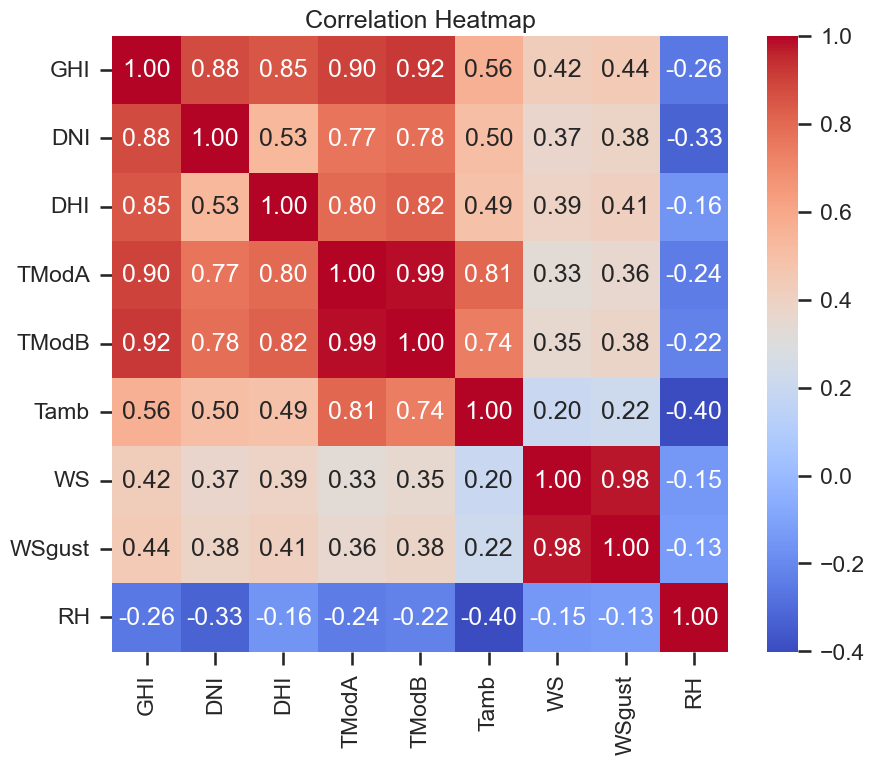

In [8]:
# Correlation heatmap
if not df.empty:
    corr_cols = [c for c in ["GHI","DNI","DHI","TModA","TModB","Tamb","WS","WSgust","RH"] if c in df]
    if corr_cols:
        corr = df[corr_cols].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
        plt.title("Correlation Heatmap")
        plt.show()
    else:
        print("No numeric columns for correlation heatmap.")
else:
    print("DataFrame is empty.")


In [ ]:
# Scatter plots: WS, WSgust, WD vs GHI; RH vs Tamb & GHI
if not df.empty:
    pairs = [
        ("WS","GHI"), ("WSgust","GHI"), ("WD","GHI"),
        ("RH","Tamb"), ("RH","GHI")
    ]
    pairs = [(x,y) for (x,y) in pairs if x in df and y in df]
    if pairs:
        cols = 2
        rows = int(np.ceil(len(pairs)/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
        axes = np.atleast_1d(axes).ravel()
        for ax, (x,y) in zip(axes, pairs):
            sns.scatterplot(data=df, x=x, y=y, s=10, alpha=0.4, ax=ax)
            sns.regplot(data=df, x=x, y=y, scatter=False, color='red', ax=ax)
            ax.set_title(f"{x} vs {y}")
        for ax in axes[len(pairs):]: ax.axis("off")
        plt.tight_layout(); plt.show()
    else:
        print("No valid pairs for scatter plots.")
else:
    print("DataFrame is empty.")


In [ ]:
# Histograms for GHI and WS
if not df.empty:
    hcols = [c for c in ["GHI","WS"] if c in df]
    if hcols:
        df[hcols].hist(figsize=(10,4), bins=40)
        plt.suptitle("Histograms")
        plt.show()
    else:
        print("No histogram columns present.")
else:
    print("DataFrame is empty.")


In [ ]:
# Wind rose (approximation using polar histogram)
if not df.empty and all(c in df.columns for c in ["WD","WS"]):
    wd = pd.to_numeric(df["WD"], errors='coerce') % 360
    ws = pd.to_numeric(df["WS"], errors='coerce')

    # Bin directions into 16 sectors (22.5° each)
    bins = np.deg2rad(np.arange(0, 361, 22.5))
    directions = np.deg2rad(wd)

    # Use counts weighted by wind speed magnitude for a simple rose
    counts, edges = np.histogram(directions, bins=bins, weights=ws)
    angles = (edges[:-1] + edges[1:]) / 2

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='polar')
    ax.bar(angles, counts, width=np.deg2rad(22.5), bottom=0.0, align='center', alpha=0.7)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_title("Wind Rose (WS weighted)")
    plt.show()
else:
    print("WD or WS not present; skipping wind rose.")


In [ ]:
# Bubble chart: GHI vs Tamb with bubble size = RH or BP
if not df.empty:
    if all(c in df.columns for c in ["GHI", "Tamb"]):
        size_col = "RH" if "RH" in df.columns else ("BP" if "BP" in df.columns else None)
        if size_col:
            x, y = "GHI", "Tamb"
            plt.figure(figsize=(8,6))
            s = pd.to_numeric(df[size_col], errors='coerce')
            s_norm = (s - np.nanmin(s)) / (np.nanmax(s) - np.nanmin(s) + 1e-9)
            sizes = 50 + s_norm * 250
            plt.scatter(pd.to_numeric(df[x], errors='coerce'), pd.to_numeric(df[y], errors='coerce'),
                        s=sizes, c=s, cmap="viridis", alpha=0.6)
            cbar = plt.colorbar(); cbar.set_label(size_col)
            plt.xlabel(x); plt.ylabel(y)
            plt.title(f"{x} vs {y} (bubble={size_col})")
            plt.show()
        else:
            print("No RH/BP column for bubble size.")
    else:
        print("Missing GHI or Tamb for bubble chart.")
else:
    print("DataFrame is empty.")
